# Exploring and Analyzing Healthcare Trends in Synthetic Medicare Data

### Team 5:

- Atharva Lokhande
- Hrishav Varma
- Shravani Thalla
- Parisa Hajirahimi
- Willem Seethaler


# Executive Summary

This thorough examination attempts to break down all the different facets of American healthcare, such as health conditions, provider availability, geographic disparities, demographic insights, and financial burdens related to healthcare services. The report offers a comprehensive assessment of the current status of healthcare in the country by carefully examining death trends, state-specific health outcomes, healthcare provider distribution, common medical conditions, treatment patterns, and the financial aspects of healthcare.

# Problem Definition:

This project aims to explore healthcare service utilization and demand based on patients demographic and outcomes. We are trying to explore the following:

- To understand how age and gender influence mortality and health outcomes.
- To identify regional disparities in health outcomes and healthcare service utilization.
- To examine the relationship between healthcare provider availability and service utilization
- To delve into the specifics of health conditions and treatment patterns across the country.
- To uncover financial disparities in healthcare payments and costs.

# Data Source:
- Center for Medicare & Medicaid Services Synthetic Patient Data:
- Google Big Query -  Synthetic Patient Data in OMOP – Marketplace – Google Cloud console - https://console.cloud.google.com/marketplace/product/hhs/synpuf
- The CMS Synthetic Patient Data in BigQuery offers a simulated snapshot of Medicare insurance claims from 2008-2010. It includes anonymized information on 2.33 million patients, encompassing diagnoses, procedures, medications, encounters, and provider details. While not reflecting real individuals, this data allows researchers to explore healthcare trends and patterns related to disease prevalence, mortality rates, provider analysis, and cost analysis.


# Motivation:

As the healthcare landscape continues to change, characterized by increasing costs, varying disease prevalence, and demographic shifts, we think it’s crucial to understand  and optimize healthcare services across various settings and populations. Our motivation is to help the US healthcare system in improving the delivery of healthcare and the distribution of resources.

# Data Description:

Center for Medicare & Medicaid Services Synthetic Patient Data:
Google Big Query -  Synthetic Patient Data in OMOP – Marketplace – Google Cloud console.

This is a synthetic patient dataset in the OMOP Common Data Model originally released by the CMS and accessed via BigQuery. The dataset includes 24 tables and records for 2 million synthetic patients from 2008 to 2010.

|          Name           | Variance |     Rows     |
|:-----------------------:|:--------:|:------------:|
| Care site               |    6     |    320,545   |
| Concept                 |    10    |  3,902,588   |
| Concept ancestor        |    4     | 118,150,608  |
| Concept class           |    3     |       300    |
| Concept relationship    |    6     | 26,727,250   |
| Condition era           |    6     | 223,393,336  |
| Condition occurrence    |    16    | 289,182,385  |
| Cost                    |    22    | 748,940,384  |
| Death                   |    7     |    107,644   |
| Device exposure         |    15    |  4,465,485   |
| Domain                  |    3     |        39    |
| Dose era                |    7     | 122,262,518  |
| Drug era                |    7     | 122,266,452  |
| Drug exposure           |    24    | 126,048,050  |
| Drug strength           |    12    |  2,415,413   |
| Location                |    8     |     3,185    |
| Observation             |    18    | 37,531,051   |
| Observation period      |    5     |  2,098,515   |
| Payer plan period       |    17    |  7,789,512   |
| Person                  |    18    |  2,326,856   |
| Procedure occurrence    |    14    | 278,769,529  |
| Provider                |    13    |    905,492   |
| Relationship            |    6     |       410    |
| Vocabulary              |    5     |        42    |



## Importing Libraries

In [ ]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from pyspark.sql.functions import col, when, avg, min, max, count, lit, to_date, concat, expr, year, datediff, countDistinct, sum as sum_, desc
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from matplotlib.colors import Normalize
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType
from sklearn.preprocessing import MinMaxScaler
import folium
import plotly.express as px
import pandas as pd
from pyspark.sql import functions as F

## Loading the Tables

In [ ]:
#load person table
person_Table = "bigquery-public-data.cms_synthetic_patient_data_omop.person"
person_df = spark.read.option("inferSchema","true") \
    .format('bigquery') \
    .option('table', person_Table) \
    .load()
person_df.limit(2).toPandas()

,race_concept_id,ethnicity_concept_id,location_id,provider_id,care_site_id,person_source_value,gender_source_value,gender_source_concept_id,race_source_value,race_source_concept_id,ethnicity_source_value,ethnicity_source_concept_id,person_id,gender_concept_id,year_of_birth,month_of_birth,day_of_birth,birth_datetime
0,8527,38003564,157,NaN,NaN,1B135662530719B8,1,NaN,1,NaN,1,NaN,477637,8507,1909,1,1,None
1,8527,38003564,438,NaN,NaN,42BE54A6BBB20E54,1,NaN,1,NaN,1,NaN,1542531,8507,1909,1,1,None


In [ ]:
#load death table
death_df = spark.read.option("inferSchema","true") \
    .format('bigquery') \
    .option('table', "bigquery-public-data.cms_synthetic_patient_data_omop.death") \
    .load()
death_df.limit(2).toPandas()

,person_id,death_date,death_datetime,death_type_concept_id,cause_concept_id,cause_source_value,cause_source_concept_id
0,35830,2010-09-01,None,38003565,NaN,None,0
1,61332,2010-09-01,None,38003565,NaN,None,0


In [ ]:
#load location table
location_df = spark.read.option("inferSchema","true") \
    .format('bigquery') \
    .option('table', "bigquery-public-data.cms_synthetic_patient_data_omop.location") \
    .load()
location_df.limit(2).toPandas()

,location_id,address_1,address_2,city,state,zip,county,location_source_value
0,26,None,None,None,54,None,54000,54-000
1,71,None,None,None,54,None,54320,54-320


In [ ]:
#load observation table
observation_df = spark.read.option("inferSchema","true") \
    .format('bigquery') \
    .option('table', "bigquery-public-data.cms_synthetic_patient_data_omop.observation_period") \
    .load()
observation_df.limit(2).toPandas()

,observation_period_id,person_id,observation_period_start_date,observation_period_end_date,period_type_concept_id
0,1497834,1660992,2008-07-20,2010-08-27,44814722
1,1012030,1122314,2008-07-20,2010-08-27,44814722


In [ ]:
# Load procedure occurrence table
procedure_occurrence_df = spark.read.option("inferSchema", "true") \
    .format('bigquery') \
    .option('table', "bigquery-public-data.cms_synthetic_patient_data_omop.procedure_occurrence") \
    .load()
procedure_occurrence_df.limit(2).toPandas()

,procedure_type_concept_id,modifier_concept_id,quantity,provider_id,visit_occurrence_id,visit_detail_id,procedure_source_value,procedure_source_concept_id,modifier_source_value,procedure_occurrence_id,person_id,procedure_concept_id,procedure_dat,procedure_datetime
0,38000251,NaN,NaN,199062,85937240,NaN,022,2000143,None,214599064,1791404,2000143,2008-08-04,None
1,38000251,NaN,NaN,44329,46994856,NaN,042,2000212,None,117361469,979478,2000212,2009-08-28,None


In [ ]:
# Load Provider table
provider_df = spark.read.option("inferSchema", "true") \
    .format('bigquery') \
    .option('table', "bigquery-public-data.cms_synthetic_patient_data_omop.provider") \
    .load()
provider_df.limit(2).toPandas()

,provider_id,provider_name,npi,dea,specialty_concept_id,care_site_id,year_of_birth,gender_concept_id,provider_source_value,specialty_source_value,specialty_source_concept_id,gender_source_value,gender_source_concept_id
0,135687,None,9232459980,None,NaN,65536,NaN,NaN,9232459980,None,NaN,None,NaN
1,135691,None,6537458182,None,NaN,65536,NaN,NaN,6537458182,None,NaN,None,NaN


In [ ]:
# Load concept table
concept_df = spark.read.option("inferSchema", "true") \
    .format('bigquery') \
    .option('table', "bigquery-public-data.cms_synthetic_patient_data_omop.concept") \
    .load()
concept_df.limit(2).toPandas()

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_date,valid_end_date,invalid_reason
0,3041910,Deprecated Gastrointestine upper Fluoroscopy W...,Observation,LOINC,Clinical Observation,None,39143-3,1970-01-01,2010-08-27,U
1,45958992,Acetate,Observation,SNOMED,Substance,None,16609611000001107,1970-01-01,2012-10-03,U


In [ ]:
# Load condition_era table
condition_era_df = spark.read.option("inferSchema", "true") \
    .format('bigquery') \
    .option('table', "bigquery-public-data.cms_synthetic_patient_data_omop.condition_era") \
    .load()
condition_era_df.limit(2).toPandas()

,condition_era_id,person_id,condition_concept_id,condition_era_start_date,condition_era_end_date,condition_occurrence_count
0,970500796,1772356,317009,2008-07-20,2008-07-20,1
1,800565126,2063,4070679,2008-07-20,2008-07-20,1


In [ ]:
# Load dose_era table
dose_era_df = spark.read.option("inferSchema", "true") \
    .format('bigquery') \
    .option('table', "bigquery-public-data.cms_synthetic_patient_data_omop.dose_era") \
    .load()
dose_era_df.limit(2).toPandas()

,dose_era_id,person_id,drug_concept_id,unit_concept_id,dose_value,dose_era_start_date,dose_era_end_date
0,286140312,791800,738818,40239104,0.0,2008-06-20,2008-07-20
1,333226223,1688192,40175932,40174336,0.0,2008-04-22,2008-05-22


In [ ]:
# Load cost table
cost_df=spark.read.option("inferSchema", "true") \
    .format('bigquery') \
    .option('table', "bigquery-public-data.cms_synthetic_patient_data_omop.cost") \
    .load()
cost_df.limit(2).toPandas()

,cost_id,cost_event_id,cost_domain_id,cost_type_concept_id,currency_concept_id,total_charge,total_cost,total_paid,paid_by_payer,paid_by_patient,...,paid_patient_deductible,paid_by_primary,paid_ingredient_cost,paid_dispensing_fee,payer_plan_period_id,amount_allowed,revenue_code_concept_id,revenue_code_source_value,drg_concept_id,drg_source_value
0,461477778,153179276,Procedure,5031,44818668,NaN,NaN,580.0,360.0,170.0,...,0.0,360.0,NaN,NaN,NaN,NaN,NaN,None,NaN,None
1,461508640,153192915,Procedure,5031,44818668,NaN,NaN,480.0,380.0,100.0,...,0.0,380.0,NaN,NaN,NaN,NaN,NaN,None,NaN,None


In [ ]:
# Load payer_plan table
payer_plan_df=spark.read.option("inferSchema", "true") \
    .format('bigquery') \
    .option('table', "bigquery-public-data.cms_synthetic_patient_data_omop.payer_plan_period") \
    .load()
payer_plan_df = payer_plan_df.select(col("plan_source_value"))
payer_plan_df.limit(2).toPandas()

,plan_source_value
0,Medicare Part B
1,Medicare Part B


### Joining Tables

In [ ]:
# Joining Person and Location with Death Table to do demographic analysis
person_df = person_df.withColumnRenamed('person_id', 'patient_id')
location_df = location_df.withColumnRenamed('location_id', 'loc_id')

death_person_join = death_df.join(person_df, death_df.person_id == person_df.patient_id, how='left')
full_join = death_person_join.join(location_df, death_person_join.location_id == location_df.loc_id, 'left')
death_person_join.drop() # Dropping intermediate table
full_join.limit(3).toPandas()

,person_id,death_date,death_datetime,death_type_concept_id,cause_concept_id,cause_source_value,cause_source_concept_id,race_concept_id,ethnicity_concept_id,location_id,...,day_of_birth,birth_datetime,loc_id,address_1,address_2,city,state,zip,county,location_source_value
0,61332,2010-09-01,None,38003565,NaN,None,0,8527,38003564,1654,...,1,None,1654,None,None,None,IA,None,16260,16-260
1,95196,2010-09-01,None,38003565,NaN,None,0,0,38003563,62,...,1,None,62,None,None,None,NY,None,33590,33-590
2,35830,2010-09-01,None,38003565,NaN,None,0,8527,38003564,522,...,1,None,522,None,None,None,LA,None,19070,19-070


In [ ]:
# Joining Observation and Person Tables
observation_df_join = observation_df.join(person_df, observation_df.person_id == person_df.patient_id, how='left')
observation_df_join.limit(3).toPandas()

,observation_period_id,person_id,observation_period_start_date,observation_period_end_date,period_type_concept_id,race_concept_id,ethnicity_concept_id,location_id,provider_id,care_site_id,...,race_source_value,race_source_concept_id,ethnicity_source_value,ethnicity_source_concept_id,patient_id,gender_concept_id,year_of_birth,month_of_birth,day_of_birth,birth_datetime
0,484874,537741,2008-07-20,2010-08-28,44814722,8527,38003564,135,NaN,NaN,...,1,NaN,1,NaN,537741,8507,1927,9,1,None
1,1411070,1564611,2008-07-20,2010-08-30,44814722,0,38003564,25,NaN,NaN,...,3,NaN,3,NaN,1564611,8507,1944,9,1,None
2,480553,532951,2008-07-20,2010-08-28,44814722,8527,38003564,1124,NaN,NaN,...,1,NaN,1,NaN,532951,8507,1940,12,1,None


In [ ]:
# Joining Concept and Condition_era table
condition_era_concept_join = condition_era_df.join(concept_df,condition_era_df.condition_concept_id == concept_df.concept_id,how='left')
condition_era_concept_join = condition_era_concept_join.join(person_df,condition_era_concept_join.person_id == person_df.patient_id,how='inner')
# Drop the redundant 'patient_id' column
condition_era_person_join = condition_era_concept_join.drop('patient_id')
condition_era_concept_join.limit(3).toPandas()

,condition_era_id,person_id,condition_concept_id,condition_era_start_date,condition_era_end_date,condition_occurrence_count,concept_id,concept_name,domain_id,vocabulary_id,...,race_source_value,race_source_concept_id,ethnicity_source_value,ethnicity_source_concept_id,patient_id,gender_concept_id,year_of_birth,month_of_birth,day_of_birth,birth_datetime
0,800365703,29,4188191,2009-02-17,2009-02-17,1,4188191,Disorder of skin pigmentation,Condition,SNOMED,...,1,NaN,1,NaN,29,8507,1938,4,1,None
1,800365699,29,136915,2009-02-17,2009-02-17,1,136915,Primary malignant neoplasm of skin of lip,Condition,SNOMED,...,1,NaN,1,NaN,29,8507,1938,4,1,None
2,800365701,29,138825,2009-02-17,2009-02-17,1,138825,Actinic keratosis,Condition,SNOMED,...,1,NaN,1,NaN,29,8507,1938,4,1,None


In [ ]:
#Joining Concept and dose_era table
dose_era_join=dose_era_df.join(concept_df, dose_era_df.drug_concept_id == concept_df.concept_id, how='left')
dose_era_join.limit(3).toPandas()

,dose_era_id,person_id,drug_concept_id,unit_concept_id,dose_value,dose_era_start_date,dose_era_end_date,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_date,valid_end_date,invalid_reason
0,358252027,2164720,705103,19006208,0.0,2008-03-18,2008-03-19,705103,lamotrigine,Drug,RxNorm,Ingredient,S,28439,1970-01-01,2099-12-31,None
1,343463694,1883056,705103,19006208,0.0,2008-05-05,2008-06-04,705103,lamotrigine,Drug,RxNorm,Ingredient,S,28439,1970-01-01,2099-12-31,None
2,290558969,875793,705103,19006208,0.0,2008-07-30,2008-08-29,705103,lamotrigine,Drug,RxNorm,Ingredient,S,28439,1970-01-01,2099-12-31,None


# Cleaning Data

In [ ]:
condition_era_concept_join = condition_era_concept_join.withColumn('gender_concept_id',
                                when(col('gender_concept_id') == 8507, 'male')
                                .otherwise('female'))

# Show the DataFrame with modified gender_concept_id
condition_era_concept_join.limit(2).toPandas()

24/04/29 20:19:09 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,condition_era_id,person_id,condition_concept_id,condition_era_start_date,condition_era_end_date,condition_occurrence_count,concept_id,concept_name,domain_id,vocabulary_id,...,race_source_value,race_source_concept_id,ethnicity_source_value,ethnicity_source_concept_id,patient_id,gender_concept_id,year_of_birth,month_of_birth,day_of_birth,birth_datetime
0,800365699,29,136915,2009-02-17,2009-02-17,1,136915,Primary malignant neoplasm of skin of lip,Condition,SNOMED,...,1,NaN,1,NaN,29,male,1938,4,1,None
1,800365700,29,137497,2009-02-17,2009-02-17,1,137497,Dermatophytosis of the body,Condition,SNOMED,...,1,NaN,1,NaN,29,male,1938,4,1,None


In [ ]:
# Dropping redundant columns on which join was performed
condition_era_join = condition_era_concept_join.drop('standard_concept', 'invalid_reason')

In [ ]:
# Handling null values in condition concept joined table
null_counts = []
for col_name in dose_era_join.columns:
    # Count the number of null values in the column
    count = dose_era_join.filter(col(col_name).isNull()).count()
    # Append the column name and null count to the list
    null_counts.append((col_name, count))

# Print the null counts for each column
for col_name, count in null_counts:
    print(f"Number of null values in column '{col_name}': {count}")

Number of null values in column 'dose_era_id': 0
Number of null values in column 'person_id': 0
Number of null values in column 'drug_concept_id': 0
Number of null values in column 'unit_concept_id': 0
Number of null values in column 'dose_value': 0
Number of null values in column 'dose_era_start_date': 0
Number of null values in column 'dose_era_end_date': 0
Number of null values in column 'concept_id': 0
Number of null values in column 'concept_name': 0
Number of null values in column 'domain_id': 0
Number of null values in column 'vocabulary_id': 0
Number of null values in column 'concept_class_id': 0
Number of null values in column 'standard_concept': 0
Number of null values in column 'concept_code': 0
Number of null values in column 'valid_start_date': 0
Number of null values in column 'valid_end_date': 0
Number of null values in column 'invalid_reason': 122262518


In [ ]:
# Dropping redundant columns on which join was performed
dose_era_join = dose_era_join.drop('invalid_reason')

In [ ]:
dose_era_join = dose_era_join.withColumn('days_required', datediff(dose_era_join['dose_era_end_date'], dose_era_join['dose_era_start_date']))

dose_era_join.limit(3).toPandas()

,dose_era_id,person_id,drug_concept_id,unit_concept_id,dose_value,dose_era_start_date,dose_era_end_date,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_date,valid_end_date,invalid_reason,days_required
0,358252027,2164720,705103,19006208,0.0,2008-03-18,2008-03-19,705103,lamotrigine,Drug,RxNorm,Ingredient,S,28439,1970-01-01,2099-12-31,None,1
1,331714670,1659448,705103,19006208,0.0,2009-06-17,2009-07-17,705103,lamotrigine,Drug,RxNorm,Ingredient,S,28439,1970-01-01,2099-12-31,None,30
2,343463694,1883056,705103,19006208,0.0,2008-05-05,2008-06-04,705103,lamotrigine,Drug,RxNorm,Ingredient,S,28439,1970-01-01,2099-12-31,None,30


In [ ]:
# Dropping redundant columns on which join was performed
full_join = full_join.drop('patient_id', 'loc_id')

In [ ]:
# Handling null values in full_join
null_counts = []
for col_name in full_join.columns:
    # Count the number of null values in the column
    count = full_join.filter(col(col_name).isNull()).count()
    # Append the column name and null count to the list
    null_counts.append((col_name, count))
for col_name, count in null_counts:
    print(f"Number of null values in column '{col_name}': {count}")

Number of null values in column 'person_id': 0
Number of null values in column 'death_date': 0
Number of null values in column 'death_datetime': 107644
Number of null values in column 'death_type_concept_id': 0
Number of null values in column 'cause_concept_id': 107644
Number of null values in column 'cause_source_value': 107644
Number of null values in column 'cause_source_concept_id': 0
Number of null values in column 'race_concept_id': 0
Number of null values in column 'ethnicity_concept_id': 0
Number of null values in column 'location_id': 0
Number of null values in column 'provider_id': 107644
Number of null values in column 'care_site_id': 107644
Number of null values in column 'person_source_value': 0
Number of null values in column 'gender_source_value': 0
Number of null values in column 'gender_source_concept_id': 107644
Number of null values in column 'race_source_value': 0
Number of null values in column 'race_source_concept_id': 107644
Number of null values in column 'ethni

In [ ]:
# Dropping columns with null values only
full_join = full_join.drop('death_datetime','cause_concept_id','cause_source_value','provider_id','care_site_id','gender_source_concept_id','race_source_concept_id','ethnicity_source_concept_id','birth_datetime','address_1','address_2','city','zip')

In [ ]:
full_join.limit(5).toPandas()

In [ ]:
# Cleaning up State values
full_join.select('state').distinct().show()

+-----+
|state|
+-----+
|   AZ|
|   SC|
|   54|
|   LA|
|   MN|
|   NJ|
|   DC|
|   OR|
|   VA|
|   RI|
|   KY|
|   WY|
|   NH|
|   MI|
|   NV|
|   WI|
|   ID|
|   CA|
|   CT|
|   NE|
+-----+
only showing top 20 rows



In [ ]:
full_join = full_join.filter(full_join.state != '54') # Handling no state value

In [ ]:
# Handing Gender values
full_join.select('gender_concept_id').distinct().show()

+-----------------+
|gender_concept_id|
+-----------------+
|             8507|
|             8532|
+-----------------+



In [ ]:
full_join = full_join.withColumn('gender_concept_id',
                                when(col('gender_concept_id') == 8507, 'male')
                                .otherwise('female'))

# Show the DataFrame with modified gender_concept_id
full_join.limit(2).toPandas()

,person_id,death_date,death_type_concept_id,cause_source_concept_id,race_concept_id,ethnicity_concept_id,location_id,person_source_value,gender_source_value,race_source_value,ethnicity_source_value,gender_concept_id,year_of_birth,month_of_birth,day_of_birth,state,county,location_source_value
0,9546,2010-08-01,38003565,0,8527,38003564,1759,149579975371D29B,1,1,1,male,1917,1,1,MN,24270,24-270
1,1909909,2008-09-01,38003565,0,8527,38003564,15,6A66D5DDE7E56191,1,1,1,male,1958,1,1,ID,13270,13-270


In [ ]:
# Cleaning up Birth Date and Death Date values
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
full_join = full_join.withColumn('combined_birth_date',
                                 to_date(concat(col('year_of_birth'), lit('-'), col('month_of_birth'), lit('-'), col('day_of_birth')), 'yyyy-MM-dd'))

In [ ]:
# Finding out age at death of the patient
full_join = full_join.withColumn('age_at_death', expr('year(death_date) - year(combined_birth_date)'))
# Show the DataFrame with age at death
full_join.limit(3).toPandas()

,person_id,death_date,death_type_concept_id,cause_source_concept_id,race_concept_id,ethnicity_concept_id,location_id,person_source_value,gender_source_value,race_source_value,ethnicity_source_value,gender_concept_id,year_of_birth,month_of_birth,day_of_birth,state,county,location_source_value,combined_birth_date,age_at_death
0,9546,2010-08-01,38003565,0,8527,38003564,1759,149579975371D29B,1,1,1,male,1917,1,1,MN,24270,24-270,1917-01-01,93
1,1909909,2008-09-01,38003565,0,8527,38003564,15,6A66D5DDE7E56191,1,1,1,male,1958,1,1,ID,13270,13-270,1958-01-01,50
2,986207,2009-10-01,38003565,0,8527,38003564,386,79F5C85B39AFCED4,1,1,1,male,1909,1,1,IA,16300,16-300,1909-01-01,100


In [ ]:
# Handling null values in observation person joined table
null_counts = []
for col_name in observation_df_join.columns:
    # Count the number of null values in the column
    count = observation_df_join.filter(col(col_name).isNull()).count()
    # Append the column name and null count to the list
    null_counts.append((col_name, count))

# Print the null counts for each column
for col_name, count in null_counts:
    print(f"Number of null values in column '{col_name}': {count}")

Number of null values in column 'observation_period_id': 0
Number of null values in column 'person_id': 0
Number of null values in column 'observation_period_start_date': 0
Number of null values in column 'observation_period_end_date': 0
Number of null values in column 'period_type_concept_id': 0
Number of null values in column 'race_concept_id': 0
Number of null values in column 'ethnicity_concept_id': 0
Number of null values in column 'location_id': 0
Number of null values in column 'provider_id': 2098515
Number of null values in column 'care_site_id': 2098515
Number of null values in column 'person_source_value': 0
Number of null values in column 'gender_source_value': 0
Number of null values in column 'gender_source_concept_id': 2098515
Number of null values in column 'race_source_value': 0
Number of null values in column 'race_source_concept_id': 2098515
Number of null values in column 'ethnicity_source_value': 0
Number of null values in column 'ethnicity_source_concept_id': 20985

In [ ]:
# Dropping all null columns
observation_df_join=observation_df_join.drop('patient_id', 'provider_id','care_site_id','gender_source_concept_id','race_source_concept_id','ethnicity_source_concept_id','birth_datetime')

In [ ]:
# Creating new feature as Observation Period Duration
observation_df_join = observation_df_join.withColumn('observation_period_duration', datediff('observation_period_end_date', 'observation_period_start_date'))
observation_df_join.limit(2).toPandas()

,observation_period_id,person_id,observation_period_start_date,observation_period_end_date,period_type_concept_id,race_concept_id,ethnicity_concept_id,location_id,person_source_value,gender_source_value,race_source_value,ethnicity_source_value,gender_concept_id,year_of_birth,month_of_birth,day_of_birth,observation_period_duration
0,480553,532951,2008-07-20,2010-08-28,44814722,8527,38003564,1124,9480085F006C80F9,1,1,1,8507,1940,12,1,769
1,571934,634269,2008-07-20,2010-08-27,44814722,8527,38003564,413,73BB89BD31824DE6,2,1,1,8532,1943,7,1,768


In [ ]:
procedure_occurrence_df_selected = procedure_occurrence_df.select("provider_id", "person_id")
procedure_occurrence_df_selected = procedure_occurrence_df_selected.na.drop(how='any')


In [ ]:
# Joining all the above tables
procedure_person_df = procedure_occurrence_df_selected.join(person_df.select("patient_id", "location_id"), person_df.patient_id == procedure_occurrence_df_selected.person_id, 'inner')
procedure_person_location_df = procedure_person_df.join(location_df, location_df.loc_id == procedure_person_df.location_id, 'inner')
procedure_person_location_provider_df = procedure_person_location_df.join(provider_df.select("provider_id", "care_site_id"), 'provider_id', 'inner')
procedure_person_location_provider_df.limit(3).toPandas()

,provider_id,person_id,patient_id,location_id,loc_id,address_1,address_2,city,state,zip,county,location_source_value,care_site_id
0,199062,1791404,1791404,390,390,None,None,None,PA,None,39770,39-770,90383
1,44329,979478,979478,62,62,None,None,None,NY,None,33590,33-590,12041
2,6130,2228884,2228884,125,125,None,None,None,OR,None,38250,38-250,4179


In [ ]:
procedure_person_location_provider_df.drop('patient_id', 'loc_id')

DataFrame[provider_id: bigint, person_id: bigint, location_id: bigint, address_1: string, address_2: string, city: string, state: string, zip: string, county: string, location_source_value: string, care_site_id: bigint]

In [ ]:
procedure_person_location_provider_df = procedure_person_location_provider_df.filter(procedure_person_location_provider_df.state != '54')

In [ ]:
# Handling null values in cost table
null_counts = []
for col_name in cost_df.columns:
    # Count the number of null values in the column
    count = cost_df.filter(col(col_name).isNull()).count()
    # Append the column name and null count to the list
    null_counts.append((col_name, count))
for col_name, count in null_counts:
    print(f"Number of null values in column '{col_name}': {count}")

Number of null values in column 'cost_id': 0
Number of null values in column 'cost_event_id': 0
Number of null values in column 'cost_domain_id': 0
Number of null values in column 'cost_type_concept_id': 0
Number of null values in column 'currency_concept_id': 0
Number of null values in column 'total_charge': 748940384
Number of null values in column 'total_cost': 748940384
Number of null values in column 'total_paid': 0
Number of null values in column 'paid_by_payer': 111085969
Number of null values in column 'paid_by_patient': 0
Number of null values in column 'paid_patient_copay': 748940384
Number of null values in column 'paid_patient_coinsurance': 0
Number of null values in column 'paid_patient_deductible': 111085969
Number of null values in column 'paid_by_primary': 0
Number of null values in column 'paid_ingredient_cost': 748940384
Number of null values in column 'paid_dispensing_fee': 748940384
Number of null values in column 'payer_plan_period_id': 748940384
Number of null val

In [ ]:
# Dropping columns with null values only
cost_df = cost_df.drop('total_charge','total_cost','paid_patient_copay','paid_ingredient_cost','paid_dispensing_fee','payer_plan_period_id','amount_allowed','revenue_code_concept_id','revenue_code_source_value','drg_concept_id','drg_source_value')

In [ ]:
# Replace NaN values with zero in the specified columns of df_cost
cost_df = cost_df.fillna({'paid_by_payer': 0, 'paid_patient_deductible': 0})

In [ ]:
cost_df = cost_df.withColumn("total_paid_calc",
                   col('paid_by_payer') +
                   col('paid_by_patient'))
cost_df.limit(3).toPandas()

,cost_id,cost_event_id,cost_domain_id,cost_type_concept_id,currency_concept_id,total_paid,paid_by_payer,paid_by_patient,paid_patient_coinsurance,paid_patient_deductible,paid_by_primary,total_paid_calc
0,461477778,153179276,Procedure,5031,44818668,580.0,360.0,170.0,170.0,0.0,360.0,530.0
1,461508640,153192915,Procedure,5031,44818668,480.0,380.0,100.0,100.0,0.0,380.0,480.0
2,461824203,153329714,Procedure,5031,44818668,330.0,320.0,100.0,100.0,0.0,320.0,420.0


# Visualisations

## 1. What is the correlation between ages of patients that have passed away and how it differs based on the patient's sex?

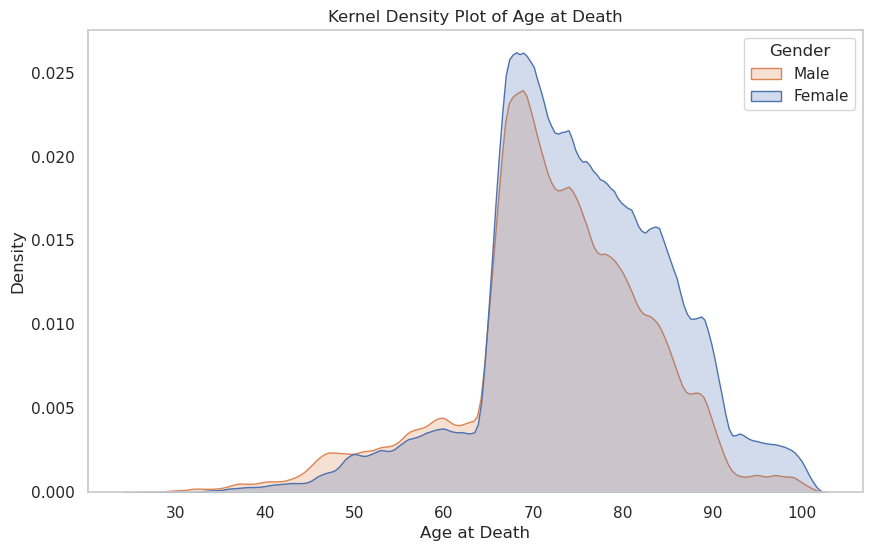

In [ ]:
full_join_pandas = full_join.select("person_id", "gender_concept_id", "age_at_death").toPandas()
full_join_pandas['age_at_death'] = full_join_pandas['age_at_death'].astype(float)

# Plot KDE plot using seaborn with different lines for each gender and scaled data
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.kdeplot(data=full_join_pandas, x="age_at_death", hue="gender_concept_id", fill=True, bw_adjust=0.5,
            hue_order=["female", "male"], legend=True)
plt.grid(False)
plt.legend(title="Gender", labels=["Male", "Female"])
plt.title("Kernel Density Plot of Age at Death")
plt.xlabel("Age at Death")
plt.ylabel("Density")
plt.show()

The graph illustrates the age at which patients pass away, differentiated by sex. Females tend to live longer, with a peak density of deaths around 80 years old, while males experience a peak around 70 years old. The decline in male death density after the peak indicates earlier mortality, whereas females have a more extended tail in the distribution, suggesting a greater likelihood of surviving into their 80s and beyond. This underscores the importance of understanding gender-specific health factors and addressing disparities in healthcare to improve overall longevity.

## 2. Which are the top states by the count of deceased patients, and how do these numbers reflect the overall health outcomes across different regions?

In [ ]:
# Group by 'state' and count rows
state_counts = full_join.groupBy('state').count().orderBy('state')
pandas_df = state_counts.toPandas()
pandas_df.head()

,state,count
0,AK,200
1,AL,2336
2,AR,1730
3,AZ,2134
4,CA,9224


In [ ]:
# Create a USA map centered on a specific location
usa_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Add a choropleth layer to the map based on state counts
folium.Choropleth(
    geo_data='https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json',
    data=pandas_df,
    columns=['state', 'count'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.8,
    line_opacity=0.3,
    legend_name='Count by State',
    highlight=True,
    name='Death Counts',
    tooltip=folium.features.GeoJsonTooltip(
        fields=['name', 'count'],
        aliases=['State:', 'Death Count:'],
        labels=True,
        sticky=True
    )
).add_to(usa_map)

# Display the map
usa_map


The darker shading on the map indicates higher death counts in specific states. Notably, the West Coast states, particularly California, exhibit a significant concentration of deaths. While the map doesn’t directly reveal water-related diseases, it’s essential to consider factors like water quality and sanitation. Contaminated water sources could contribute to health issues. Additionally, wildfires and other health conditions play a crucial role in mortality rates.

In [ ]:
sorted_df = pandas_df.sort_values(by='count', ascending=False)
sorted_df.reset_index(inplace=True)
# Print the top 5 and bottom 5 states
print("Top 5 States by Death Count:")
for index, row in sorted_df[:5].iterrows():
    print(f"\t{index}. {row[1]}: {row[2]}")

print("\nBottom 5 States by Death Count:")
for index, row in sorted_df[-5:].iterrows():
    print(f"\t{index}. {row[1]}: {row[2]}")

Top 5 States by Death Count:
	0. CA: 9224
	1. FL: 7264
	2. TX: 6168
	3. NY: 6064
	4. PA: 4682

Bottom 5 States by Death Count:
	46. SD: 397
	47. ND: 385
	48. VT: 304
	49. DC: 275
	50. AK: 200


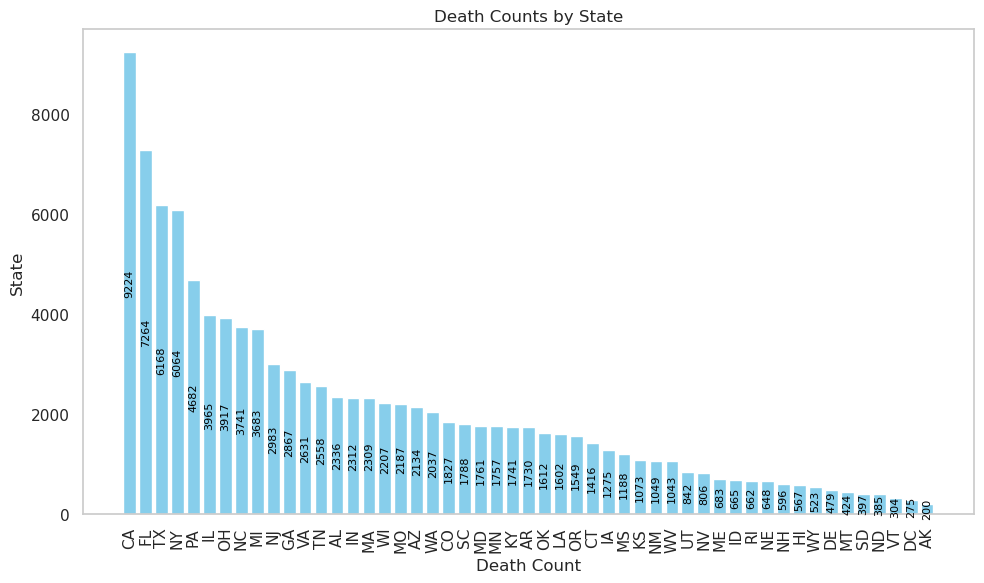

In [ ]:
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_df['state'], sorted_df['count'], color='skyblue')

plt.xlabel('Death Count')
plt.ylabel('State')
plt.title('Death Counts by State')

# Rotate x-axis labels vertically
plt.xticks(rotation=90, ha='center')

# Add value labels inside each bar vertically with rotation
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval/2, round(yval), va='center', ha='center', fontsize=8, color='black', rotation=90)

# Remove the grid lines
plt.grid(False)
plt.tight_layout()
plt.show()

The bar plot represents the death counts by state. This helps us understand which states have more deaths in the data.

## 3. What is the recovery time for individuals who have utilized Medicare services in the United States, and how does it correlate with their overall health outcomes?

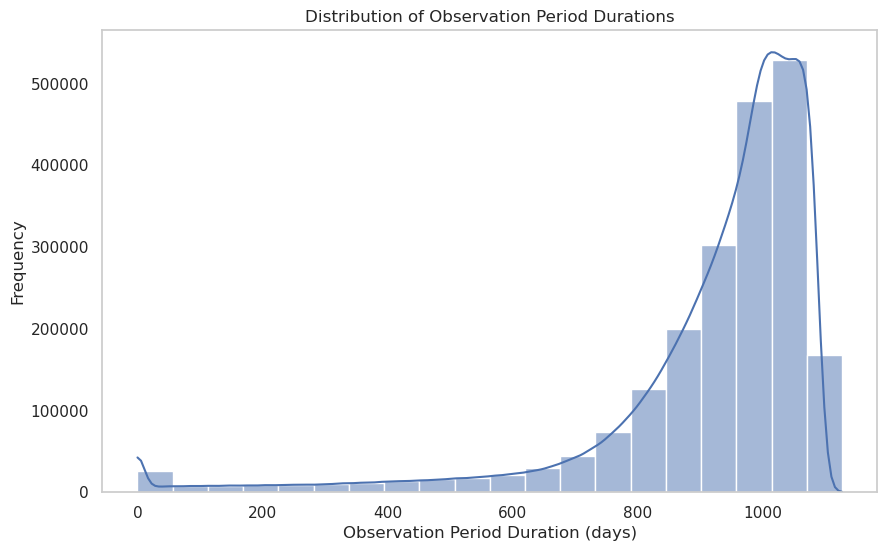

In [ ]:
duration_values = observation_df_join.select('observation_period_duration').rdd.flatMap(lambda x: x).collect()

# Create a histogram to visualize the distribution of observation period durations
plt.figure(figsize=(10, 6))
sns.histplot(duration_values, bins=20, kde=True)
plt.xlabel('Observation Period Duration (days)')
plt.ylabel('Frequency')
plt.title('Distribution of Observation Period Durations')
plt.grid(False)
plt.show()

The x-axis represents the duration of observation periods in days, while the y-axis shows the frequency (count) of observation periods within each duration range. Notably, a significant spike occurs around 800-1000 days, indicating that many people experience prolonged observation periods. These extended durations may be attributed to various factors: chronic illnesses, severe health conditions, or complex treatments. Healthcare providers should consider these varying recovery times when managing patients, and public health interventions should address the needs of those with extended observation periods. In summary, this graph underscores the importance of tailored healthcare approaches.

## 4. What are the top 10 states by the number of providers and total visits, how does the availability of healthcare providers correlate with patient visits?

In [ ]:
# Count distinct person_ids for each provider_id within each state
provider_visits = procedure_person_location_provider_df.groupBy(['state', 'provider_id']) \
                                                       .agg(countDistinct('person_id').alias('visits'))

# Sum visits for each state and count distinct providers, then order by the number of providers
state_aggregates = provider_visits.groupBy('state') \
                                  .agg(countDistinct('provider_id').alias('num_providers'),
                                       sum_('visits').alias('total_visits')) \
                                  .orderBy(desc('num_providers'))

top_states = state_aggregates.limit(10)
top_states.show()

+-----+-------------+------------+
|state|num_providers|total_visits|
+-----+-------------+------------+
|   FL|       177364|     6928272|
|   CA|       129654|     7503349|
|   NY|       122500|     5578903|
|   TX|        85193|     6042879|
|   IL|        82487|     3924077|
|   PA|        80524|     3936568|
|   AZ|        72604|     1488555|
|   NJ|        70699|     2929887|
|   MI|        66182|     3352334|
|   OH|        64595|     3566125|
+-----+-------------+------------+



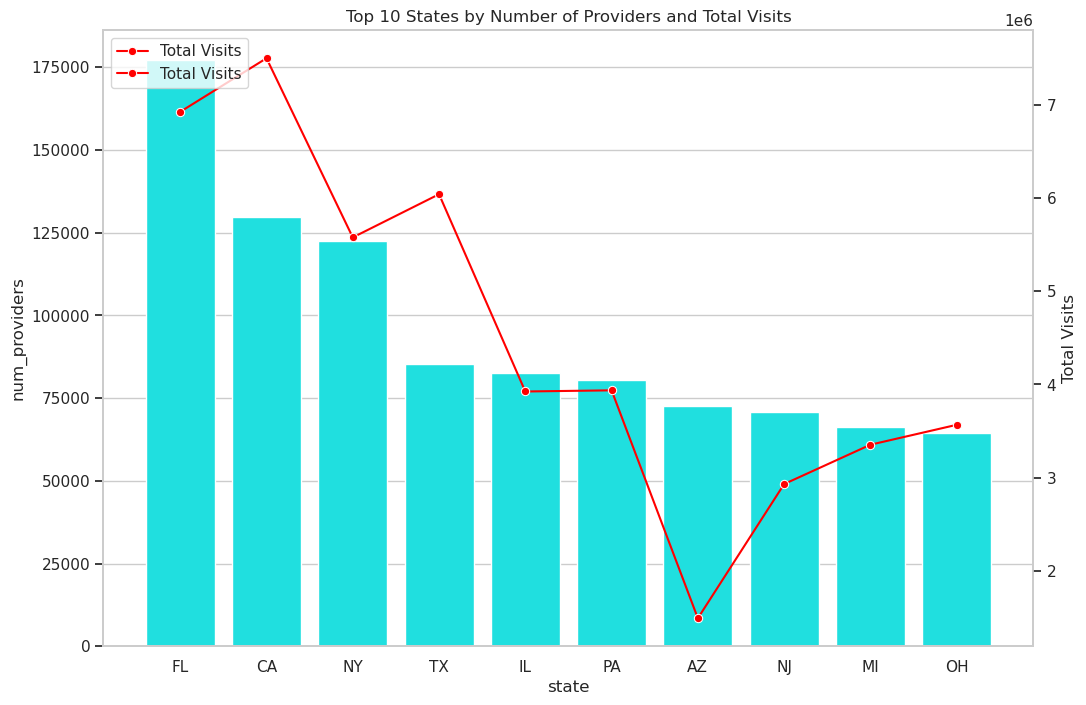

In [ ]:
top_states_pd = top_states.toPandas()
plt.figure(figsize=(12, 8))

# Plotting the number of providers
sns.barplot(data=top_states_pd, x='state', y='num_providers', color='cyan', label='Number of Providers')

# Adding a secondary y-axis for the number of visits
ax2 = plt.twinx()
sns.lineplot(data=top_states_pd, x='state', y='total_visits', marker='o', sort=False, color='red', label='Total Visits', ax=ax2)

plt.title('Top 10 States by Number of Providers and Total Visits')
plt.xlabel('State')
plt.ylabel('Total Visits')
handles1, labels1 = ax2.get_legend_handles_labels()
handles2, labels2 = plt.gca().get_legend_handles_labels()
plt.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

plt.grid(False)
plt.show()

Florida (FL) and California (CA) have the highest number of healthcare providers among the states shown. This could be due to the larger population size or a higher density of healthcare facilities.There is variability in the total visits to providers across states. Some states with a relatively high number of providers, such as AZ, do not correspond to a similarly high number of total visits. This might indicate that the provider capacity is not being fully utilized or that the patient-to-provider ratio is lower.

The total visits are concentrated in fewer states, as indicated by the total visits' line peaking in certain states like NY, suggesting that these states might be medical hubs that attract patients from broader regions.For healthcare policymakers and planners, the mismatch between the number of providers and patient visits could imply that resources are not distributed optimally. It may be beneficial to delve deeper into the causes, such as insurance coverage patterns, accessibility, or geographical factors, that contribute to this mismatch.

## 5. Visualising the distribution of medical providers among the different states and comparing it with US census data of the population of the states.

In [ ]:
census_data_state_population = spark.read.csv("gs://is843-team5-bucket/notebooks/jupyter/data/census_data_population_size.csv", header=True, inferSchema=True)
census_data_state_population.show(2)

+-------+-------+
|  state|   2015|
+-------+-------+
|Alabama|4852347|
| Alaska| 737498|
+-------+-------+
only showing top 2 rows



ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/miniconda3/share/proj failed


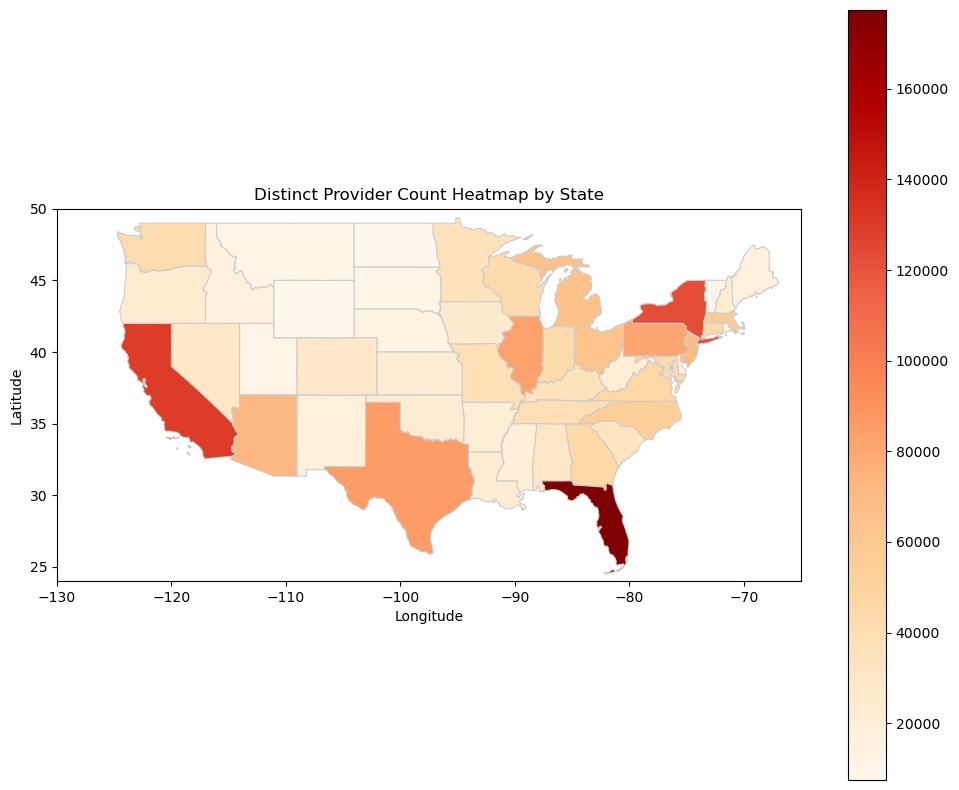

In [ ]:
state_aggregates_pandas = state_aggregates.toPandas()

# Define the URL for the US states shapefile
shapefile_url = "https://www2.census.gov/geo/tiger/GENZ2019/shp/cb_2019_us_state_20m.zip"

# Load the US states shapefile from the URL
us_states = gpd.read_file(shapefile_url)

# Filter to include only the contiguous United States (excluding Alaska and Hawaii)
contiguous_us_states = us_states.loc[us_states['STUSPS'].isin(['WA', 'ME', 'FL', 'CA', 'TX', 'NY', 'MI', 'MN', 'WI', 'GA', 'ND', 'SD', 'MT', 'ID', 'WY', 'UT', 'CO', 'NM', 'AZ', 'NV', 'OR', 'KS', 'OK', 'NE', 'IA', 'MO', 'AR', 'LA', 'MS', 'AL', 'TN', 'KY', 'IL', 'IN', 'OH', 'WV', 'VA', 'NC', 'SC', 'DC', 'MD', 'DE', 'PA', 'NJ', 'CT', 'RI', 'MA', 'NH', 'VT'])]

# Merge shapefile with grouped_df based on state abbreviations
merged_df = contiguous_us_states.merge(state_aggregates_pandas, left_on='STUSPS', right_on='state', how='left')

# Plot the heatmap
fig, ax = plt.subplots(figsize=(12, 10))
merged_df.plot(column='num_providers', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Set the extent of the map to focus on the contiguous United States
ax.set_xlim(-130, -65)  # Adjust the values as needed
ax.set_ylim(24, 50)  # Adjust the values as needed

# Set plot title and labels
ax.set_title('Distinct Provider Count Heatmap by State')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Display the plot
plt.show()

As we can see, the number of providers are mostly concentrated in the densely populated states but this does not tell the whole picture. Let's now scale the provider count with the population sizes of each state by using the US census data and see which states have the highest availability of medical providers per capita.

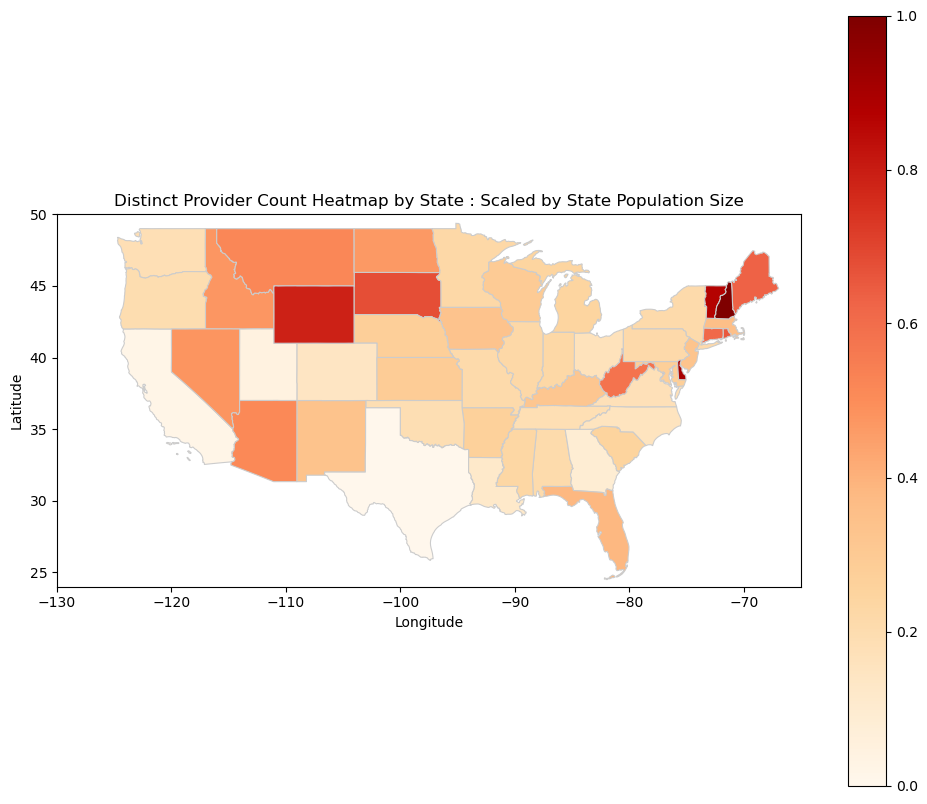

In [ ]:
# Define the mapping between full state names and two-digit notations
state_mapping = {
    'Washington': 'WA',
    'Maine': 'ME',
    'Florida': 'FL',
    'California': 'CA',
    'Texas': 'TX',
    'New York': 'NY',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Wisconsin': 'WI',
    'Georgia': 'GA',
    'North Dakota': 'ND',
    'South Dakota': 'SD',
    'Montana': 'MT',
    'Idaho': 'ID',
    'Wyoming': 'WY',
    'Utah': 'UT',
    'Colorado': 'CO',
    'New Mexico': 'NM',
    'Arizona': 'AZ',
    'Nevada': 'NV',
    'Oregon': 'OR',
    'Kansas': 'KS',
    'Oklahoma': 'OK',
    'Nebraska': 'NE',
    'Iowa': 'IA',
    'Missouri': 'MO',
    'Arkansas': 'AR',
    'Louisiana': 'LA',
    'Mississippi': 'MS',
    'Alabama': 'AL',
    'Tennessee': 'TN',
    'Kentucky': 'KY',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Ohio': 'OH',
    'West Virginia': 'WV',
    'Virginia': 'VA',
    'North Carolina': 'NC',
    'South Carolina': 'SC',
    'District of Columbia': 'DC',
    'Maryland': 'MD',
    'Delaware': 'DE',
    'Pennsylvania': 'PA',
    'New Jersey': 'NJ',
    'Connecticut': 'CT',
    'Rhode Island': 'RI',
    'Massachusetts': 'MA',
    'New Hampshire': 'NH',
    'Vermont': 'VT'
}

# Convert the state names to two-digit notations in the Spark DataFrame
census_data_state_population = census_data_state_population.withColumn("state", col("state").cast("string"))
census_data_state_population = census_data_state_population.replace(state_mapping, subset='state')
census_data_state_population = census_data_state_population.withColumnRenamed("2015", "population_2015")

# Convert the Spark DataFrame to Pandas DataFrame for joining
census_data_state_population_pandas = census_data_state_population.toPandas()

# Perform the join using the 'state' column
census_providers_merged_df = pd.merge(census_data_state_population_pandas, state_aggregates_pandas, on='state', how='inner')

census_providers_merged_df['num_providers_scaled'] = census_providers_merged_df['num_providers'] / census_providers_merged_df['population_2015']
scaler = MinMaxScaler()
census_providers_merged_df['num_providers_scaled'] = scaler.fit_transform(census_providers_merged_df[['num_providers_scaled']])
census_providers_merged_df.head()


scaled_merged_df = contiguous_us_states.merge(census_providers_merged_df, left_on='STUSPS', right_on='state', how='left')
# Plot the heatmap
fig, ax = plt.subplots(figsize=(12, 10))
scaled_merged_df.plot(column='num_providers_scaled', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Set the extent of the map to focus on the contiguous United States
ax.set_xlim(-130, -65)  # Adjust the values as needed
ax.set_ylim(24, 50)  # Adjust the values as needed

# Set plot title and labels
ax.set_title('Distinct Provider Count Heatmap by State : Scaled by State Population Size')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Display the plot
plt.show()

In [ ]:
top_5_states = scaled_merged_df.nlargest(5, 'num_providers_scaled')
print("Top 5 States with most medical providers per person:")
for state_name, scaled_value in zip(top_5_states['state'], top_5_states['num_providers_scaled']):
    state_code = next((code for code, name in state_mapping.items() if name == state_name), None)
    print(f"\t{state_code}")

Top 5 States with most medical providers per person:
	New Hampshire
	District of Columbia
	Delaware
	Vermont
	Wyoming


## 6. Is the number of medical specialties available in each state sufficient for the number of patients and the overall population in that state?

In [ ]:
# Load Provider table
prescriber_df = spark.read.option("inferSchema", "true") \
    .format('bigquery') \
    .option('table', "bigquery-public-data.cms_medicare.part_d_prescriber_2014") \
    .load()
selected_df = prescriber_df.select("nppes_provider_state", "specialty_description")

# List of non-U.S. states, territories, and military postal designations
non_us_states = ['AA', 'ZZ', 'DC', 'XX', 'GU', 'VI', 'PR', 'AE', 'AS', 'AP','MP']

# Filter out rows with non-U.S. states
filtered_df = selected_df.filter(~col('nppes_provider_state').isin(non_us_states))

In [ ]:
Medical_Specialties = [
    "Diagnostic Radiology", "Cardiac Electrophysiology", "Geriatric Psychiatry",
    "Neuromusculoskeletal Medicine, Sports Medicine", "Physical Medicine and Rehabilitation", "Neurosurgery",
    "Nephrology", "Pathology", "Radiation Oncology", "Rheumatology", "Physical Medicine & Rehabilitation",
    "Optometry", "Hospice and Palliative Care", "Geriatric Medicine", "Osteopathic Manipulative Medicine",
    "Critical Care (Intensivists)", "Peripheral Vascular Disease", "Urology", "Nuclear Medicine",
    "Pulmonary Disease", "Infectious Disease", "Endocrinology", "Neurological Surgery",
    "Hematology/Oncology", "Sleep Medicine", "Cardiology", "Pain Management", "Surgical Oncology",
    "Internal Medicine", "Hematology", "Interventional Cardiology", "Medical Genetics", "Neurology",
    "Obstetrics & Gynecology", "Gynecological/Oncology", "Family Medicine", "Anesthesiology", "Pediatric Medicine",
    "Psychiatry", "Psychiatry & Neurology", "Dermatology", "Allergy/Immunology", "Emergency Medicine",
    "Legal Medicine", "Addiction Medicine", "Preventive Medicine", "Clinical Pharmacology", "Sports Medicine",
    "Medical Oncology","Obstetrics/Gynecology","Ophthalmology", "Clinical Neuropsychologist", "Hospital (Dmercs Only)",
    "Naturopath", "Behavioral Analyst", "Occupational therapist", "Community Health Worker",
    "Registered Dietician/Nutrition Professional", "Midwife", "Medical Genetics, Ph.D. Medical Genetics",
    "Neuropsychiatry", "Electrodiagnostic Medicine", "Homeopath"
]


Surgical_Specialties = [
    "Orthopaedic Surgery", "Oral & Maxillofacial Surgery", "Colorectal Surgery (formerly proctology)",
    "General Surgery", "Plastic Surgery", "Oral Surgery (dentists only)", "Podiatry",
    "Hand Surgery", "Cardiac Surgery", "Maxillofacial Surgery", "Vascular Surgery", "Thoracic Surgery",
    "Plastic and Reconstructive Surgery", "Obstetrics/Gynecology (surgical aspects)","Orthopedic Surgery",
     "Thoracic Surgery (Cardiothoracic Vascular Surgery)", "Colon & Rectal Surgery", "Dentist", "Otolaryngology",
    "Specialist"
]


Allied_Health_Support_Services = [
    "Nurse's Aide", "Speech Language Pathologist", "Registered Nurse", "Licensed Vocational Nurse",
    "Clinical Psychologist", "Psychologist (billing independently)", "Chiropractic",
    "Student in an Organized Health Care Education/Training Program", "Occupational Therapist",
    "Physician Assistant", "General Acute Care Hospital", "Respite Care", "Radiologic Technologist",
    "Unknown Supplier/Provider", "Denturist", "Physical Therapist", "Interventional Pain Management",
    "Hospitalist", "Certified Clinical Nurse Specialist", "Clinic/Center",
    "Health Maintenance Organization", "Massage Therapist", "Personal Emergency Response Attendant",
    "Psychologist", "Licensed Clinical Social Worker", "General Practice", "Rehabilitation Agency",
    "Rehabilitation Practitioner", "Case Manager/Care Coordinator", "Counselor", "Gastroenterology",
    "Licensed Practical Nurse", "Surgery", "Specialist/Technologist, Other", "Adult Companion",
    "Case Management", "Chore Provider", "Emergency Medical Technician, Intermediate", "Prosthetist",
    "Spec/Tech, Cardiovascular", "Physical Therapy Assistant", "Radiology Practitioner Assistant",
    "Residential Treatment Facility, Emotionally Disturbed Children", "Rehabilitation Counselor",
    "Anesthesiologist Assistants", "Ambulatory Surgical Center", "Dental Assistant",
    "Audiologist (billing independently)", "Military Hospital",
    "Marriage & Family Therapist", "Respiratory Therapist, Certified", "Pharmacy Technician",
    "Community/Behavioral Health", "Licensed Psychiatric Technician", "Specialist/Technologist",
    "Naprapath", "Optician", "Pediatrics", "Occupational Therapy Assistant", "Technician",
    "Hearing Instrument Specialist", "Technician/Technologist", "Genetic Counselor, MS", "Home Health Aide",
    "Spec/Tech, Pathology", "Nursing Facility, Other (Dmercs Only)", "Centralized Flu", "Mechanotherapist",
    "Clinical Medical Laboratory", "Psychiatric Residential Treatment Facility", "Mass Immunization Roster Biller",
    "Pharmacy", "Dental Laboratory Technician", "Doula", "Health Educator", "Medical Supply Company, Other",
    "SNF (Dmercs Only)", "Lactation Consultant, Non-RN", "Recreation Therapist", "CRNA", "Pharmacist",
    "Independent Medical Examiner", "Exclusive Provider Organization", "Preferred Provider Organization",
    "Point of Service", "Multispecialty Clinic/Group Practice", "Public Health Welfare Agency",
    "Slide Preparation Facility", "Nutritionist", "Driver", "Military Health Care Provider",
    "Unknown Physician Specialty Code", "Dental Hygienist", "Phlebotomy", "Certified Nurse Midwife",
    "Substance Abuse Rehabilitation Facility",  "Contractor", "Durable Medical Equipment & Medical Supplies", "Phlebology",
    "Interventional Radiology", "Nurse Practitioner", "Radiology", "Psychoanalyst",
    "Social Worker", "Emergency Medical Technician, Basic", "Chronic Disease Hospital","Family Practice",
    "Acupuncturist","Religious Nonmedical Nursing Personnel"
]

In [ ]:
from pyspark.sql.functions import when

# Define the conditions for each group
conditions = [
    (filtered_df['specialty_description'].isin(Medical_Specialties)),
    (filtered_df['specialty_description'].isin(Surgical_Specialties)),
    (filtered_df['specialty_description'].isin(Allied_Health_Support_Services)),
]

# Define the corresponding group names
group_names = ['Medical_Specialties', 'Surgical_Specialties', 'Allied_Health_Support_Services']

# Create a new column 'specialty_group' based on the conditions
filtered_df = filtered_df.withColumn('specialty_group',
                                     when(conditions[0], group_names[0])
                                    .when(conditions[1], group_names[1])
                                    .when(conditions[2], group_names[2])
                                    .otherwise('Other'))
# Show the DataFrame with the new column
filtered_df.limit(2).toPandas()

,nppes_provider_state,specialty_description,specialty_group
0,OH,Physician Assistant,Allied_Health_Support_Services
1,CA,Family Practice,Allied_Health_Support_Services


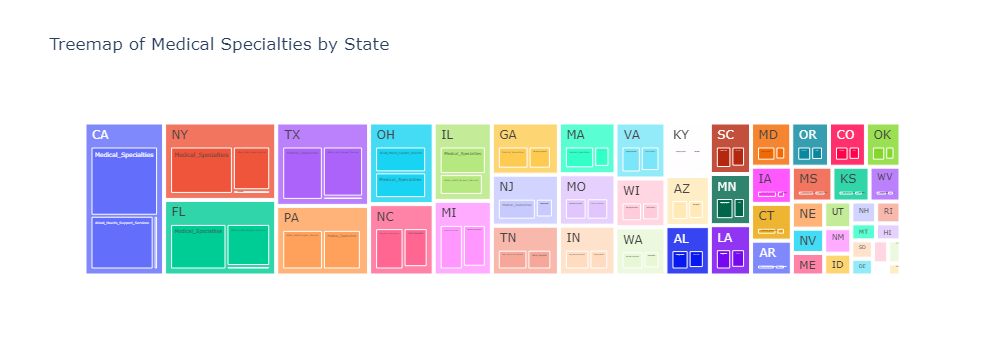

In [1]:
import plotly.express as px
aggregated_df = filtered_df.groupBy("nppes_provider_state", "specialty_group") \
                           .count() \
                           .withColumnRenamed("count", "specialty_count")
pandas_df = aggregated_df.toPandas()

# Create a treemap
fig = px.treemap(pandas_df, path=['nppes_provider_state', 'specialty_group'], values='specialty_count',
                 title='Treemap of Medical Specialties by State')
fig.show()

The treemap shows a variety of medical specialties across states, with each state displaying at least one category of specialty. This indicates a nationwide spread of medical expertise.
California (CA), New York (NY), and Texas (TX) all point to a greater concentration of medical specializations. These states might offer better coverage for their populations because they have a wider range of specialties available.
Greater areas dedicated to medical specialties can be seen in states like Texas, New York, and California, which may suggest a more robust healthcare system that can handle a wider range of medical needs or a larger population.

## 7. What are the top 10 states by the number of providers and total visits, how does the availability of healthcare providers correlate with patient visits?

In [ ]:
# Count unique person_ids per care_site_id
care_site_utilization = procedure_person_location_provider_df.groupBy('care_site_id') \
                                                             .agg(countDistinct('person_id').alias('unique_persons_count'))\
                                                             .orderBy('unique_persons_count', ascending=False)
care_site_utilization_pd = care_site_utilization.toPandas()
care_site_utilization_pd.head()

,care_site_id,unique_persons_count
0,40,607936
1,94,445617
2,393,431940
3,13,270323
4,382,165498


In [ ]:
care_site_utilization_pd = care_site_utilization_pd.sort_values(by='unique_persons_count', ascending=False)

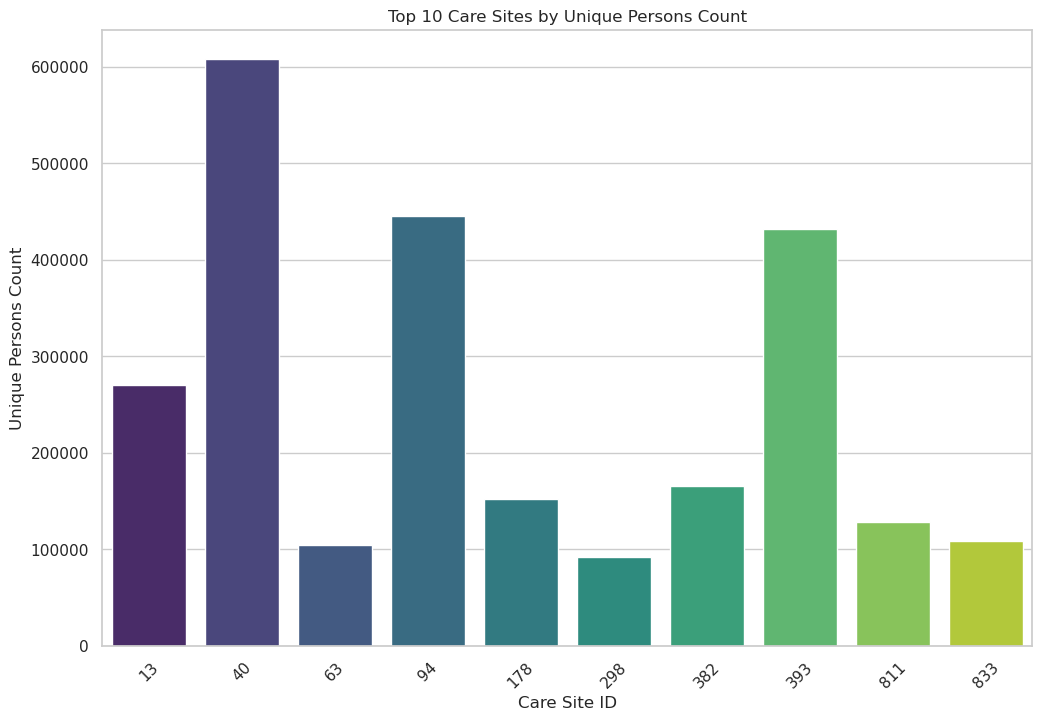

In [ ]:
top_care_sites = care_site_utilization_pd.head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x=top_care_sites['care_site_id'], y=top_care_sites['unique_persons_count'], palette='viridis')
plt.title('Top 10 Care Sites by Unique Persons Count')
plt.xlabel('Care Site ID')
plt.ylabel('Unique Persons Count')
plt.xticks(rotation=45)
plt.show()


Care site 40 stands out with the highest unique person count, significantly more than the other sites. This site may be a major hospital or clinic, serving a large community or offering specialized services that attract a higher volume of patients.There is considerable variability in the number of unique visits among these top care sites.The drastic differences in patient counts could imply either overutilization of certain sites (like site 40 and 94) leading to potential strain on resources and staff, or underutilization of others, which could signal inefficiencies or accessibility issues.It could also point to an uneven distribution of healthcare services or varying levels of healthcare access across different areas

## 8. What are the top 10 medical conditions with the highest prevalence across the United States?

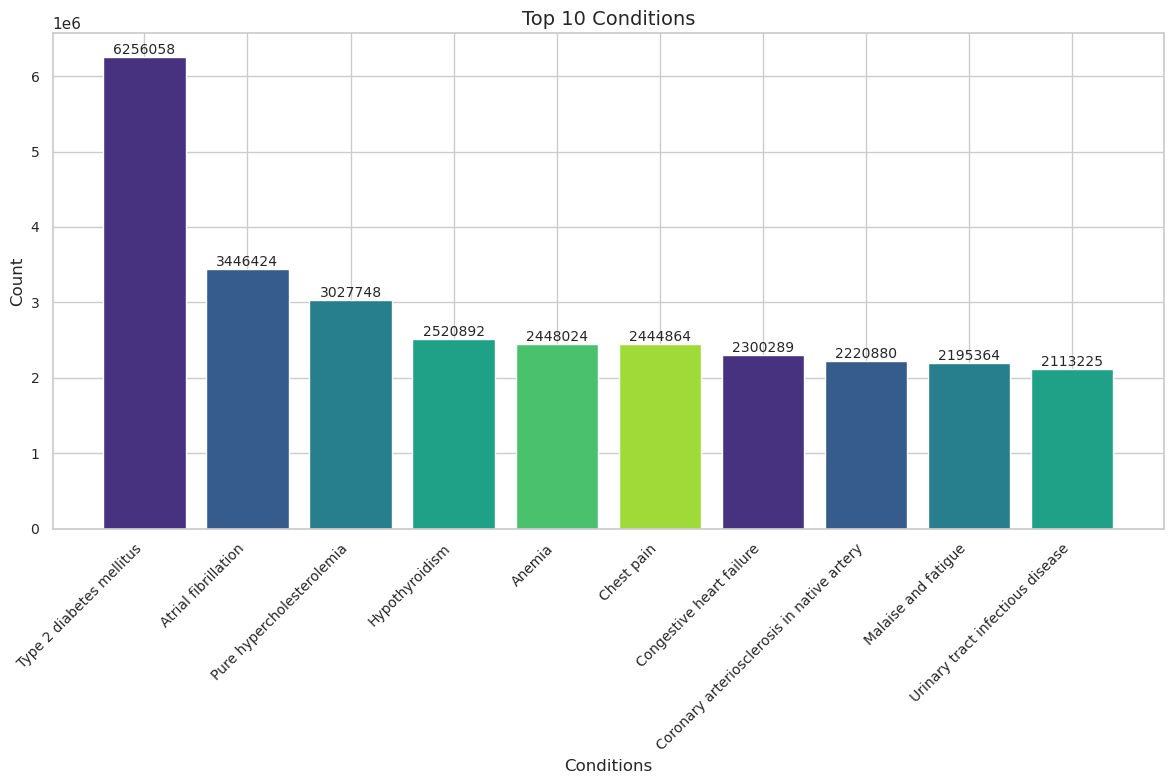

In [ ]:
concept_counts = condition_era_join.groupby('concept_name').count().alias('concept_count')

top_10_concepts = concept_counts.sort('count', ascending=False).limit(10)

top_10_concepts_pd = top_10_concepts.toPandas()

colors = sns.color_palette("viridis")

plt.figure(figsize=(12, 8))
bars = plt.bar(top_10_concepts_pd['concept_name'], top_10_concepts_pd['count'], color=colors)
plt.xlabel('Conditions', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Top 10 Conditions', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

The data reveals Type 2 diabetes mellitus as the most prevalent condition in the United States, affecting over 6 million individuals, followed by atrial fibrillation and pure hypercholesterolemia. These findings underscore the significant impact of metabolic and cardiovascular disorders on public health. The prominence of conditions such as hypothyroidism, anemia, and chest pain highlights the multifaceted nature of health challenges faced by Americans. Addressing these prevalent conditions requires comprehensive strategies focusing on prevention, management, and public health awareness to improve overall well-being and reduce disease burden across the nation.

## 9. What are the variations in medical conditions observed between genders?

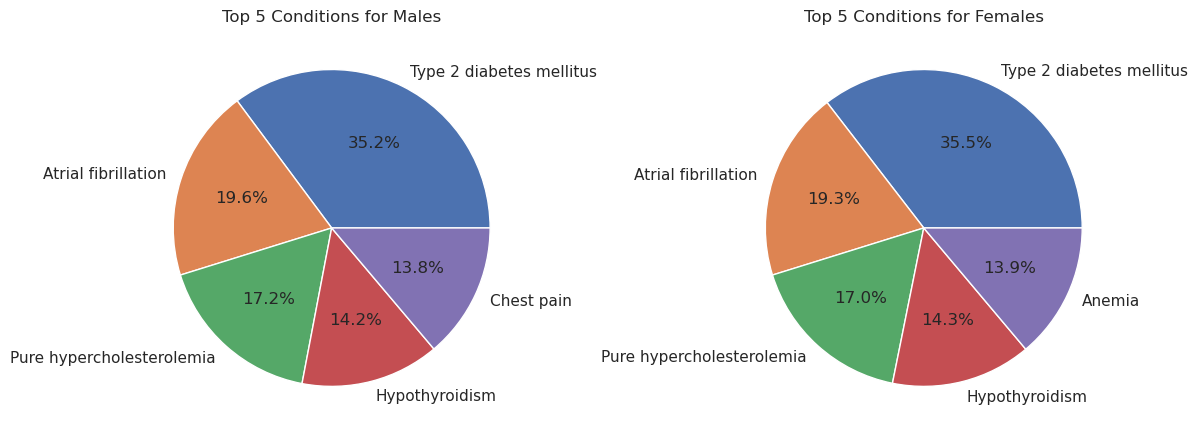

In [ ]:
male_conditions = condition_era_concept_join.filter(condition_era_concept_join.gender_concept_id == 'male')
female_conditions = condition_era_concept_join.filter(condition_era_concept_join.gender_concept_id == 'female')

# Group by concept name and count for male and female
male_counts = male_conditions.groupby('concept_name').count().alias('concept_count')
female_counts = female_conditions.groupby('concept_name').count().alias('concept_count')

# Sorting top 5 conditions for males and females
top_5_male_concepts = male_counts.sort('count', ascending=False).limit(5).toPandas()
top_5_female_concepts = female_counts.sort('count', ascending=False).limit(5).toPandas()

# Plotting pie chart for males
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.pie(top_5_male_concepts['count'], labels=top_5_male_concepts['concept_name'], autopct='%1.1f%%')
plt.title('Top 5 Conditions for Males')

# Plotting pie chart for females
plt.subplot(1, 2, 2)
plt.pie(top_5_female_concepts['count'], labels=top_5_female_concepts['concept_name'], autopct='%1.1f%%')
plt.title('Top 5 Conditions for Females')

plt.tight_layout()
plt.show()


Analysis:-It's evident that both genders share similar prevalent medical conditions, with only one discrepancy noted. While the top five conditions remain consistent between males and females, the sixth-ranked condition differs. For males, it's Anemia, while for females, it's Chest Pain. Despite this distinction, the overall alignment suggests a significant overlap in health concerns between genders. This finding underscores the importance of gender-sensitive healthcare approaches while also highlighting the need for further exploration into the underlying factors contributing to gender-specific health disparities.

## 10. What are the top 10 most frequently prescribed medications in the United States, and what insights do they offer into medication usage patterns and healthcare trends?

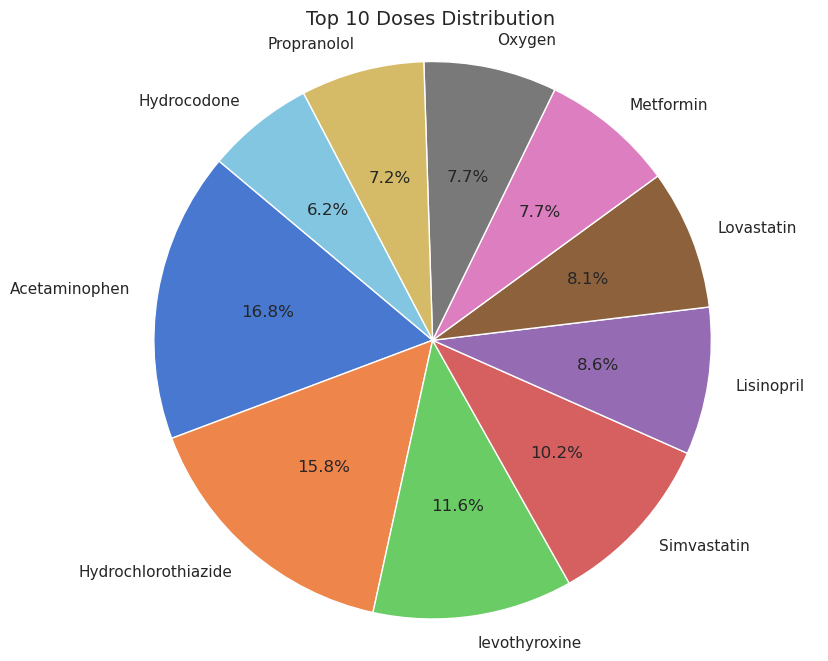

In [ ]:
# Convert the bar chart to a pie chart
top_10_concepts_pd = top_10_concepts.toPandas()
colors = sns.color_palette("muted", n_colors=10)

# Create the pie chart
plt.figure(figsize=(10, 8))
plt.pie(top_10_concepts_pd['count'], labels=top_10_concepts_pd['concept_name'], colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Doses Distribution', fontsize=14)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


Analysis:- Pointing out that the medications listed may not align precisely with the top conditions is crucial. For instance, Acetaminophen, commonly used for fever, may not correlate directly with specific ailments. Similarly, Hydrochlorothiazide, Levothyroxine, and Simvastatin, though vital for treating distinct conditions, don't necessarily reflect the most prevalent diseases. This disparity underscores the reality that many conditions share common symptoms, necessitating the widespread use of medications like Acetaminophen. It highlights the nuanced nature of healthcare, where symptomatic relief plays a vital role alongside targeted treatments for specific conditions.

## 11. Which medications have the longest duration of dosage administration?

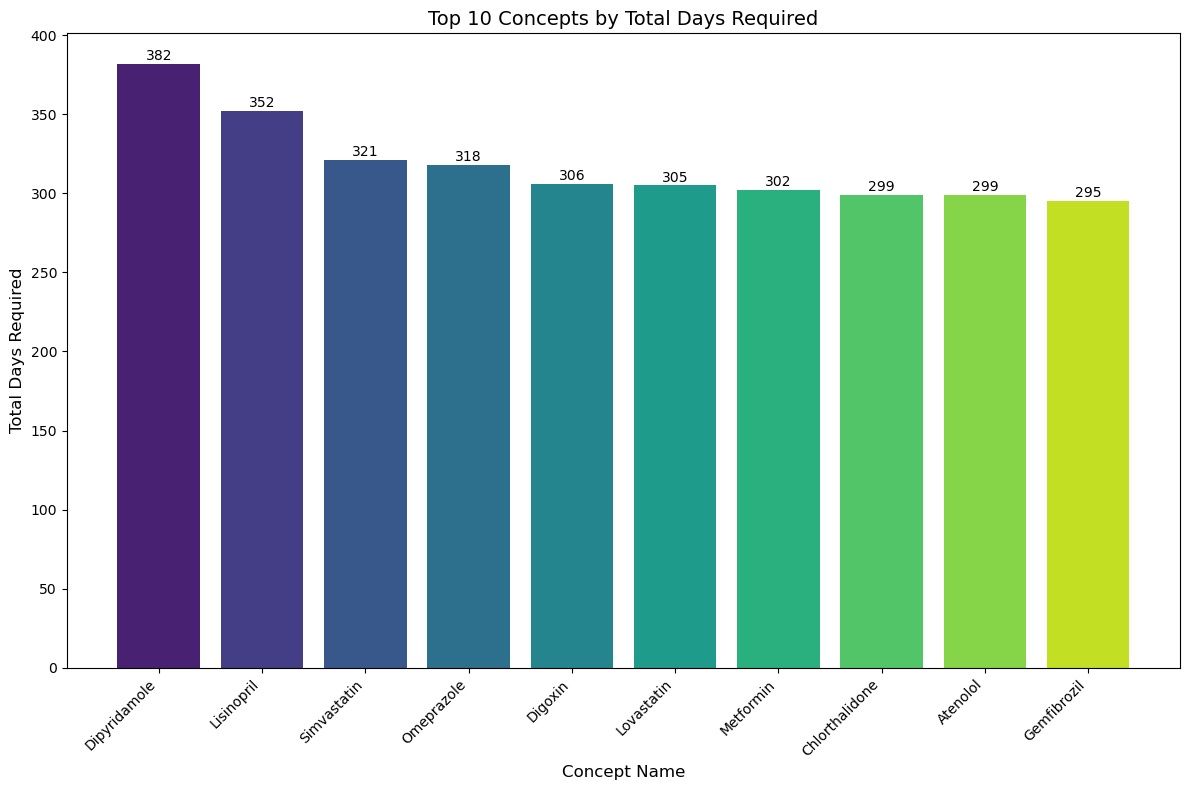

In [ ]:
concept_counts = dose_era_join.groupBy('concept_name').agg(F.max('days_required').alias('total_days'))
top_10_concepts = concept_counts.orderBy(F.desc('total_days')).limit(10)
top_10_concepts_pd = top_10_concepts.toPandas()
colors = sns.color_palette("viridis", n_colors=10)

# Create the bar chart
plt.figure(figsize=(12, 8))
bars = plt.bar(top_10_concepts_pd['concept_name'], top_10_concepts_pd['total_days'], color=colors)
plt.xlabel('Concept Name', fontsize=12)
plt.ylabel('Total Days Required', fontsize=12)
plt.title('Top 10 Concepts by Total Days Required', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Add data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


Analysis:- The list of medications with the longest duration of dosage administration, including Dipyridamole, Lisinopril, Simvastatin, Omeprazole, Digoxin, and Lovastatin, suggests their association with conditions that necessitate extended treatment periods. These medications are often prescribed for chronic conditions such as cardiovascular diseases, hypertension, and gastrointestinal disorders, which typically require long-term management rather than short-term interventions. The inclusion of these medications underscores the enduring nature of certain illnesses, highlighting the importance of sustained treatment regimens in managing chronic health conditions effectively. It also hints at the potential severity of these diseases, which may require prolonged medical intervention and care over an extended period to achieve optimal outcomes.

## 12. What is the proportion of costs paid by the patient versus the payer for a given procedure?

In [ ]:
payment_summary = cost_df.groupby("cost_domain_id").agg(
    F.sum("paid_by_payer").alias("total_paid_by_payer"),
    F.sum("paid_by_patient").alias("total_paid_by_patient"),
    F.sum("total_paid_calc").alias("total_paid_calc")
)

In [ ]:
payment_summary= payment_summary.toPandas()

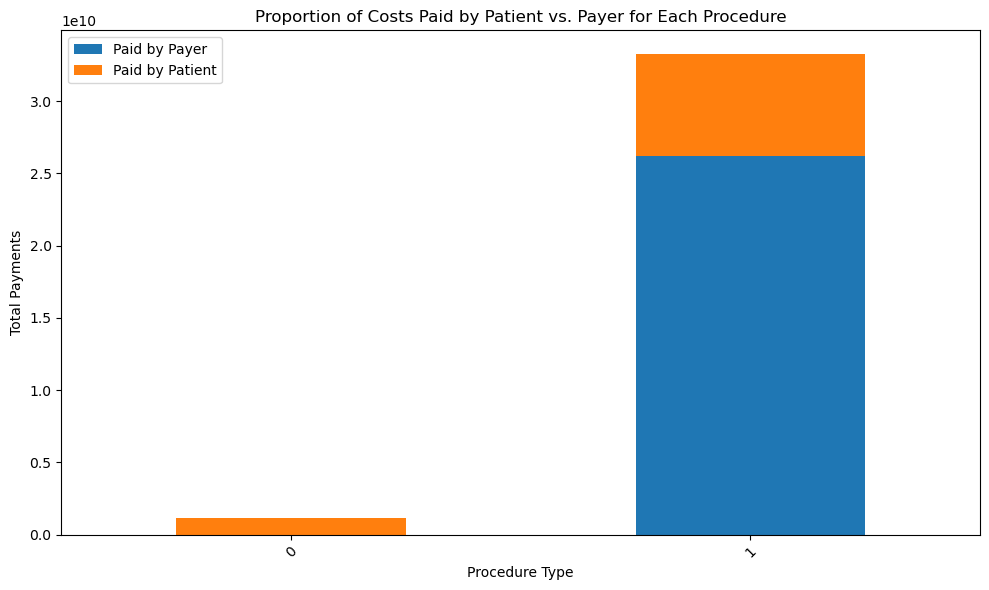

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


In [ ]:
import matplotlib.pyplot as plt
# Plotting the data as a stacked bar chart
ax = payment_summary[['total_paid_by_payer', 'total_paid_by_patient']].plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['#1f77b4', '#ff7f0e']
)
ax.set_title('Proportion of Costs Paid by Patient vs. Payer for Each Procedure')
ax.set_xlabel('Procedure Type')
ax.set_ylabel('Total Payments')
ax.legend(["Paid by Payer", "Paid by Patient"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 13. How does the patient's share of payment break down into copay, coinsurance, and deductible?

In [ ]:
# Collect the sums of coinsurance and deductible from the DataFrame
coinsurance_total = cost_df.select(F.sum('paid_patient_coinsurance')).collect()[0][0]
deductible_total = cost_df.select(F.sum('paid_patient_deductible')).collect()[0][0]

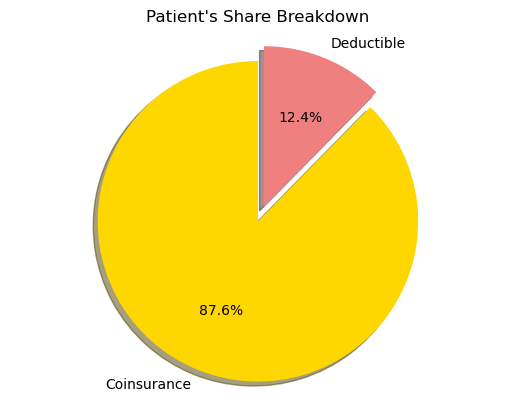

In [ ]:
# Breakdown of patient's share
labels = 'Coinsurance', 'Deductible'
sizes = [coinsurance_total, deductible_total]
colors = ['gold', 'lightcoral']
explode = (0.1, 0)  # explode 1st slice

# Plotting the pie chart
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Patient's Share Breakdown")
plt.show()

This chart illustrates the breakdown of a patient's share of healthcare payments, segmented by coinsurance and deductible categories. A majority of 87.7% is attributed to coinsurance, indicating that a significant portion of the patient's responsibility lies in sharing the cost of healthcare services with the insurer once the deductible has been met. On the other hand, the deductible—the amount the patient pays out-of-pocket before the insurer starts to contribute—accounts for a smaller fraction of 12.3%. This distribution signals that once patients have crossed their deductible threshold, their financial obligations due to healthcare expenses comes from coinsurance. This visualization was created in order to get a better understanding of the financial burdens patients face from healthcare treatment, and how much of their payments are covered by coinsurance.

## 14. What is the distribution of medical plans across the United States?

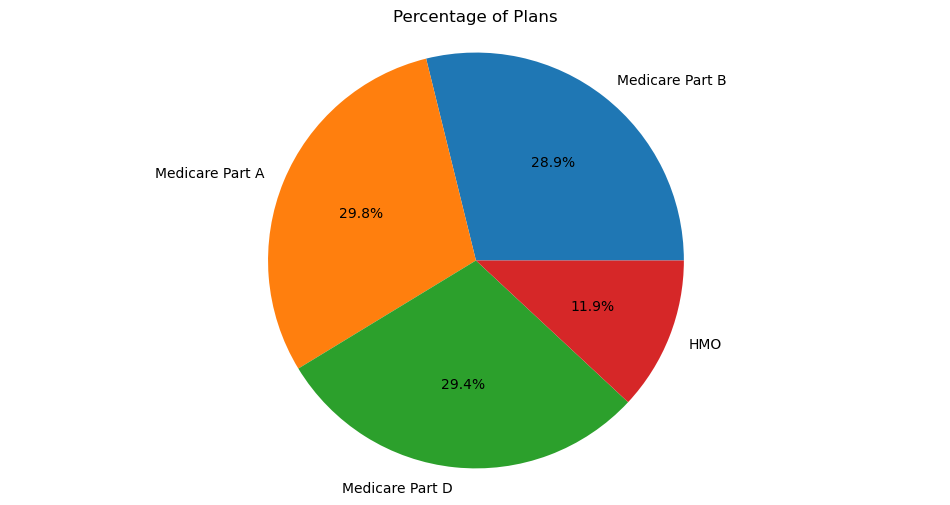

In [ ]:
plan_counts = payer_plan_df.groupby("plan_source_value").count()

# Convert the counts to pandas DataFrame for easier plotting
plan_counts_pd = plan_counts.toPandas()

# Plotting the pie chart
plt.figure(figsize=(12, 6))
plt.pie(plan_counts_pd["count"], labels=plan_counts_pd["plan_source_value"], autopct='%1.1f%%')
plt.title("Percentage of Plans")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

As we can see, medicare plan part A lead the most, followed by part B, part D and HMO.

## 15. Is there a pattern in the discrepancies related to the total cost or patient share?

In [ ]:
sampled_df = cost_df.sample(False, 0.001, seed=843)
pandas_df = sampled_df.toPandas()

In [ ]:
pandas_df = pandas_df.withColumn("total_paid_calc",
                   col('paid_by_payer') +
                   col('paid_by_patient'))
pandas_df.limit(3).toPandas()

,cost_id,cost_event_id,cost_domain_id,cost_type_concept_id,currency_concept_id,total_charge,total_cost,total_paid,paid_by_payer,paid_by_patient,...,paid_by_primary,paid_ingredient_cost,paid_dispensing_fee,payer_plan_period_id,amount_allowed,revenue_code_concept_id,revenue_code_source_value,drg_concept_id,drg_source_value,total_paid_calc
0,461477778,153179276,Procedure,5031,44818668,NaN,NaN,580.0,360.0,170.0,...,360.0,NaN,NaN,NaN,NaN,NaN,None,NaN,None,530.0
1,461508640,153192915,Procedure,5031,44818668,NaN,NaN,480.0,380.0,100.0,...,380.0,NaN,NaN,NaN,NaN,NaN,None,NaN,None,480.0
2,461824203,153329714,Procedure,5031,44818668,NaN,NaN,330.0,320.0,100.0,...,320.0,NaN,NaN,NaN,NaN,NaN,None,NaN,None,420.0


In [ ]:
pandas_df = pandas_df.withColumn('discrepancy', col('total_paid_calc') - col('total_paid'))
pandas_df = pandas_df.withColumn('discrepancy_percentage', (col('discrepancy') / col('total_paid')) * 100)

In [ ]:
pandas_df.limit(3).toPandas()

,cost_id,cost_event_id,cost_domain_id,cost_type_concept_id,currency_concept_id,total_charge,total_cost,total_paid,paid_by_payer,paid_by_patient,...,paid_dispensing_fee,payer_plan_period_id,amount_allowed,revenue_code_concept_id,revenue_code_source_value,drg_concept_id,drg_source_value,total_paid_calc,discrepancy,discrepancy_percentage
0,461477778,153179276,Procedure,5031,44818668,NaN,NaN,580.0,360.0,170.0,...,NaN,NaN,NaN,NaN,None,NaN,None,530.0,-50.0,-8.620690
1,461508640,153192915,Procedure,5031,44818668,NaN,NaN,480.0,380.0,100.0,...,NaN,NaN,NaN,NaN,None,NaN,None,480.0,0.0,0.000000
2,461824203,153329714,Procedure,5031,44818668,NaN,NaN,330.0,320.0,100.0,...,NaN,NaN,NaN,NaN,None,NaN,None,420.0,90.0,27.272727


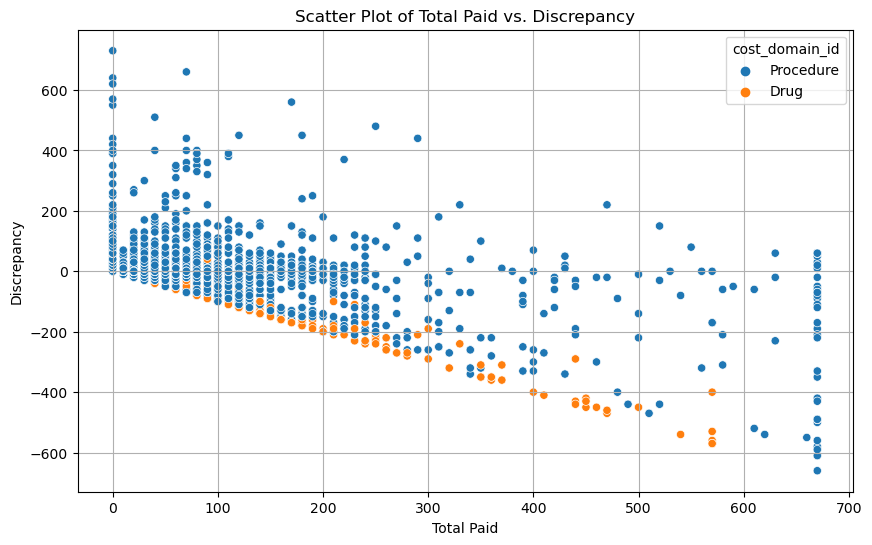

In [ ]:
# Visualization 3: Scatter plot of Total Paid vs. Discrepancy
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_paid', y='discrepancy', data=pandas_df, hue='cost_domain_id')
plt.title('Scatter Plot of Total Paid vs. Discrepancy')
plt.xlabel('Total Paid')
plt.ylabel('Discrepancy')
plt.grid(True)
plt.show()


 ### Chart SummaryComparison Between Drugs and Procedures:
"Drug" costs appear to have a lower discrepancy overall compared to "Procedures," suggesting that the costs for drugs might be more predictable or consistent.
"Procedure" costs show a wider variation in Discrepancy as Total Paid increases, which could indicate less predictability in the costs associated with medical procedures.

- The Discrepancy values range widely from positive to negative. Positive values suggest that the actual amount paid was more than expected, while negative values indicate the opposite.
Total Paid has a wide range but is more concentrated in the lower range of values.

 - There is a higher density of data points for Procedures with a lower Total Paid, which may imply that most of the procedures fall into a lower cost bracket.

# Conclusions

The examination of the healthcare system in the United States reveals a complicated web of interactions between healthcare resource allocation, geographic dispersion, and demographic characteristics that affect health outcomes as a whole. Important findings consist of:

- Gender and Mortality: Given that men and women live longer lives on average than women do, more individualized healthcare interventions are needed to increase life expectancy and improve both sexes' quality of life.
- Regional Differences in Health: The need for region-specific health interventions and improved access to high-quality healthcare is highlighted by the discovery of regional differences in death rates and healthcare service utilization.
- Inefficiencies in the Use of Healthcare: Reevaluating how healthcare resources are distributed and used is necessary in light of the apparent discrepancy between patient visits and healthcare provider availability across states. A more balanced approach that balances provider capacity with patient needs should be the goal.
- National Health Challenges: To effectively address the widespread health issues revealed by this study, targeted public health initiatives and resource allocation are required.
- Financial Burdens of Medical Care: A significant financial burden is placed on patients by the financial analysis, especially when it comes to procedural care. This indicates the urgent need for policy changes that lower out-of-pocket costs and increase insurance coverage in order to lower the cost of healthcare.

Policymakers, healthcare providers, and stakeholders must work together to implement targeted interventions based on demographic needs, regional characteristics, and economic factors in light of these findings. In order to improve healthcare equity and outcomes across the country, these strategies must be refined and adjusted to new health trends through ongoing research and data analysis.

# Declaration
- ChatGPT: We used AI to help us do some grammatic corrections and to help us condense our summaries.
- We also used ChatGPT to group the specialisations of medical providers in order to cluster them based on expertise.

# References and Documentation

- https://python-visualization.github.io/folium/latest/
- https://pandas.pydata.org/
- https://numpy.org/doc/stable/reference/index.html
- https://spark.apache.org/docs/latest/api/python/index.html
- https://matplotlib.org/
- https://seaborn.pydata.org/